In [17]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# Load your training CSV file
train_csv_path = '/Users/Athithyaraagul/Developer/sentiment-analysis/dataset/train.csv' 
train_df = pd.read_csv(train_csv_path)

# Load your testing CSV file
test_csv_path = '/Users/Athithyaraagul/Developer/sentiment-analysis/dataset/test.csv'
test_df = pd.read_csv(test_csv_path)

In [5]:
label_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

In [6]:
# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, sentiments):
        self.texts = texts
        self.sentiments = sentiments
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment = str(self.sentiments[idx])
        encoding = self.tokenizer(
            text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'sentiment': torch.tensor(label_encoding[sentiment])  # Convert sentiment to tensor
        }

In [7]:
# Create the training dataset
train_dataset = SentimentDataset(train_df['text'], train_df['sentiment'])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Create the testing dataset
test_dataset = SentimentDataset(test_df['text'], test_df['sentiment'])
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Load or define your tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_df['sentiment'])))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Training loop
num_epochs = 2

# If your using Apple's Metal, use the following line
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# If your using CUDA, use the following line
# device = torch.device('cuda' if torch.backends.mps.is_available() else 'cpu')

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
# Set up DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

Testing Epoch 1/2: 100%|██████████| 442/442 [00:24<00:00, 17.91it/s]


Epoch 1/2:
Training Accuracy: 0.7641643317200976, Training Loss: 0.5669773453196058
Test Accuracy: 0.8002263723825693, Test Loss: 0.4842023781892671


Testing Epoch 2/2: 100%|██████████| 442/442 [00:24<00:00, 18.22it/s]


Epoch 2/2:
Training Accuracy: 0.8414904843346313, Training Loss: 0.3990766577551638
Test Accuracy: 0.7713638936049801, Test Loss: 0.5463518761309092
Mean Training Accuracy: 0.8028274080273644
Mean Test Accuracy: 0.7857951329937747


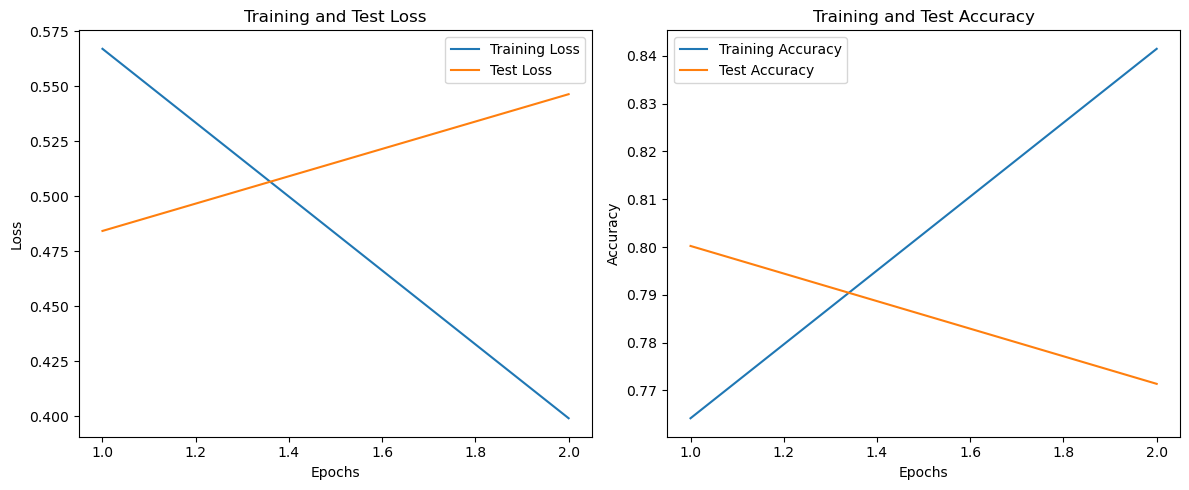

In [12]:
# Lists to store training and test metrics for each epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    
    # Train the model
    model.train()
    train_loss = 0
    correct_predictions_train = 0
    total_samples_train = 0

    for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'sentiment'}
        labels = batch['sentiment'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions_train += (predicted == labels).sum().item()
        total_samples_train += labels.size(0)

        loss.backward()
        optimizer.step()

    # Calculate and append training metrics
    train_accuracy = correct_predictions_train / total_samples_train
    train_loss /= len(train_dataloader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    
    # Evaluate on the test dataset
    model.eval()
    test_loss = 0
    correct_predictions_test = 0
    total_samples_test = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f'Testing Epoch {epoch + 1}/{num_epochs}'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'sentiment'}
            labels = batch['sentiment'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            correct_predictions_test += (predicted == labels).sum().item()
            total_samples_test += labels.size(0)

    # Calculate and append test metrics
    test_accuracy = correct_predictions_test / total_samples_test
    test_loss /= len(test_dataloader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Print training and test metrics
    print(f'Epoch {epoch + 1}/{num_epochs}:')
    print(f'Training Accuracy: {train_accuracy}, Training Loss: {train_loss}')
    print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

# Compute mean training and test accuracy
mean_train_accuracy = sum(train_accuracies) / len(train_accuracies)
mean_test_accuracy = sum(test_accuracies) / len(test_accuracies)

# Print mean training and test accuracy
print(f'Mean Training Accuracy: {mean_train_accuracy}')
print(f'Mean Test Accuracy: {mean_test_accuracy}')

# Plot training and test metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Save the model and tokenizer
output_dir = '/Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_model/'

# Create the output directory if it doesn't exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f'Model and tokenizer saved to {output_dir}')

Model and tokenizer saved to /Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_model/


In [20]:
# Save the model's state_dict
torch.save(model.state_dict(), 'pytorch_model.bin')

In [21]:
from transformers import BertTokenizer

# Initialize or load your tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Specify the directory where you want to save the tokenizer files
tokenizer_dir = '/Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_tokenizer/'

# Save tokenizer files
tokenizer.save_pretrained(tokenizer_dir)


('/Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_tokenizer/tokenizer_config.json',
 '/Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_tokenizer/special_tokens_map.json',
 '/Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_tokenizer/vocab.txt',
 '/Users/Athithyaraagul/Developer/sentiment-analysis/models/bert_tokenizer/added_tokens.json')